### Zespół 4:
- Jakub Smuga
- Konrad Korus
- Maksym Kazhaiev

## Imports



In [ ]:
!pip install SALib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.8/778.8 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split
from SALib.sample import sobol as sobol_sample
from SALib.analyze import sobol
from SALib.analyze import pawn
from SALib.sample import saltelli
from scipy.stats import ks_2samp
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import shuffle

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import mean_squared_error


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
from enum import Enum

class AnalysisMethod(Enum):
    SOBOL = "Sobol"
    PAWN = "Pawn"

## Helper functions

In [ ]:
random_shuffle_state = 2024

def train_valid_test_split(features, targets, valid_p = 0.1, test_p = 0.3):
  # shuffle the features and targets in the same way
  features = shuffle(features, random_state = random_shuffle_state)
  targets = shuffle(targets, random_state = random_shuffle_state)
  train_size = int(len(features) * (1 - (test_p + valid_p)))
  valid_size = int(len(features) * valid_p)

  X_train, X_valid, X_test = features[:train_size], features[train_size:train_size + valid_size], features[train_size + valid_size:]
  y_train, y_valid, y_test = targets[:train_size], targets[train_size:train_size + valid_size], targets[train_size + valid_size:]
  return (X_train, y_train, X_valid, y_valid, X_test, y_test)

In [ ]:
def plot_accuracy(removed_inputs_history, train_accuracy_history, valid_accuracy_history, test_accuracy_history):
    if removed_inputs_history == None:
        removed_inputs_history = range(len(train_accuracy_history))

    plt.figure(figsize=(10, 6))

    plt.plot(removed_inputs_history, train_accuracy_history, marker='o', linestyle='-', color='b', label='Train Accuracy')
    plt.plot(removed_inputs_history, valid_accuracy_history, marker='s', linestyle='-', color='g', label='Validation Accuracy')
    plt.plot(removed_inputs_history, test_accuracy_history, marker='^', linestyle='-', color='r', label='Test Accuracy')

    plt.xlabel('Removed Input History')
    plt.ylabel('Accuracy')
    plt.title('Accuracy during removal of features')
    plt.legend()

    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_time(removed_inputs_history, time_history):
    if removed_inputs_history == None:
        removed_inputs_history = range(len(time_history))

    plt.figure(figsize=(10, 6))

    plt.plot(removed_inputs_history, time_history, label='Time')

    plt.xlabel('Removed Input History')
    plt.ylabel('Time')
    plt.title('Time during removal of features')
    plt.legend()

    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_analysis(removed_inputs_history, analysis_history, average_analysis_history, label):
    if removed_inputs_history == None:
        removed_inputs_history = range(len(analysis_history))

    plt.figure(figsize=(10, 6))

    plt.plot(removed_inputs_history, analysis_history, label=f"{label} analysis value for removed neuron")
    plt.plot(removed_inputs_history, average_analysis_history, label=f"{label} Average analysis value")

    plt.xlabel('Removed Input History')
    plt.ylabel('Analysis')
    plt.title(f'{label} Analysis during removal of features')
    plt.legend()

    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def save_model(model, filename):
    torch.save(model.state_dict(), filename)

def load_model(model, filename):
    model.load_state_dict(torch.load(filename))

##First Layer

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)

        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.bn2 = nn.BatchNorm1d(output_dim)

        self.fc3 = nn.Linear(output_dim, 1)

    def forward(self, x):
        x = self.bn1(self.fc1(x))
        x = nn.functional.relu(x)

        x = self.bn2(self.fc2(x))
        x = nn.functional.relu(x)

        out = self.fc3(x)
        return out

In [ ]:
def trainAndGetLowestAnalysisValueForFirstLayer (model, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor,  X_test_tensor, y_test_tensor, analysis_method, columns):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epochs = 50
    batch_size = 32

    problem = {
        'num_vars':  X_train_tensor.shape[1],
        'names': [f'x{i+1}' for i in range( X_train_tensor.shape[1])],
        'bounds': [[0, 1]] *  X_train_tensor.shape[1]
    }

    learning_time_start = time.time()
    for epoch in range(epochs):
        for i in range(0, len(X_train_tensor[:(len(X_train_tensor) // 32) * 32]), batch_size):
            inputs = X_train_tensor[i:i+batch_size]
            labels = y_train_tensor[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            outputs = model(X_train_tensor)
            _, predicted = torch.max(outputs, 1)
            train_accuracy = (predicted == y_train_tensor).sum().item() / len(y_train_tensor)

            outputs = model(X_valid_tensor)
            _, predicted = torch.max(outputs, 1)
            valid_accuracy = (predicted == y_valid_tensor).sum().item() / len(y_valid_tensor)

            outputs = model(X_test_tensor)
            _, predicted = torch.max(outputs, 1)
            test_accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)

            if epoch == epochs - 1:
                learning_time = time.time() - learning_time_start;
                print(f"Loss: {loss.item():.4f}, Training Accuracy: {train_accuracy:.4f}, Valid Accuracy: {valid_accuracy:.4f}, , Test Accuracy: {test_accuracy:.4f}")

                param_values = sobol_sample.sample(problem, 1024)
                param_tensor = torch.tensor(param_values, dtype=torch.float32)

                if analysis_method == AnalysisMethod.SOBOL:
                  Y = model(param_tensor).detach().numpy().flatten()
                  Si = sobol.analyze(problem, Y, print_to_console=False)
                  min_sobol_index=np.argmin(Si['S1'])
                  avarage_value=np.mean(Si['S1'])
                  print(f"[Sobol] Dropping neuron with index {min_sobol_index} (column: {columns[min_sobol_index]}) |  Sobol value =  {Si['S1'][min_sobol_index]:.5f} | Avg Sobol value: {avarage_value:.5f}")
                  return min_sobol_index, train_accuracy, valid_accuracy, test_accuracy, learning_time, Si['S1'][min_sobol_index], avarage_value

                elif analysis_method == AnalysisMethod.PAWN:
                  Y = model(param_tensor)
                  _, Y = torch.max(Y, 1)
                  Si = pawn.analyze(problem, param_values, Y, print_to_console=False)
                  min_pawn_index=np.argmin(Si['median'])
                  avarage_value=np.mean(Si['median'])
                  print(f"[PAWN] Dropping neuron with index {min_pawn_index} (column: {columns[min_pawn_index]}) |  PAWN value =  {Si['CV'][min_pawn_index]:.5f} | Avg PAWN value: {avarage_value:.5f} ")
                  return  min_pawn_index, train_accuracy, valid_accuracy, test_accuracy, learning_time, Si['CV'][min_pawn_index], avarage_value

                else:
                  print("Wrong analysis method!")


def trainWhileRemovingInputsBasedOnAnalysisForFirstLayer (X, y, hidden_dim, analysis_method):
    removed_inputs_history = []
    train_accuracy_history = []
    valid_accuracy_history = []
    test_accuracy_history = []
    time_history = []
    analysis_history = []
    average_analysis_history = []

    for trainIndex in range(len(X.columns)):
        print(f"---------------------------------------- Iteration {trainIndex+1} ----------------------------------------")
        X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(X, y)

        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)
        X_test = scaler.transform(X_test)

        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
        X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
        y_valid_tensor = torch.tensor(y_valid.to_numpy(), dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

        input_dim = X_train_tensor.shape[1]
        output_dim = len(np.unique(y_train))
        model = MLP(input_dim, hidden_dim, output_dim)

        removed_input, train_accureacy, valid_accuracy, test_accuracy, time, analysis_value, average_analysis_value = trainAndGetLowestAnalysisValueForFirstLayer(model, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, X_test_tensor, y_test_tensor, analysis_method, X.columns)
        removed_inputs_history.append(X.columns[removed_input])
        train_accuracy_history.append(train_accureacy)
        valid_accuracy_history.append(valid_accuracy)
        test_accuracy_history.append(test_accuracy)
        time_history.append(time)
        analysis_history.append(analysis_value)
        average_analysis_history.append(average_analysis_value)

        X = X.drop(X.columns[removed_input], axis=1)
        print("")


    return removed_inputs_history, train_accuracy_history, valid_accuracy_history, test_accuracy_history, time_history, analysis_history, average_analysis_history

## Second Layer


In [ ]:
# Definicja modelu MLP
class MLP2(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP2, self).__init__()
        # self.fc1 = nn.Linear(input_dim, hidden_dim)
        # self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.functional.relu
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)

        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

        self.fc3 = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        # x = self.relu(self.fc2(x))
        # x = self.fc3(x)
        # return x

        # x = self.bn1(self.fc1(x))
        # x = nn.functional.relu(x)

        x = self.bn2(self.fc2(x))
        x = self.relu(x)

        out = self.fc3(x)
        return out

# Definicja modelu MLP
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        # self.fc1 = nn.Linear(input_dim, hidden_dim)
        # self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.functional.relu
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)

        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x = self.relu(self.fc1(x))
        # x = self.relu(self.fc2(x))
        # x = self.fc3(x)
        x = self.bn1(self.fc1(x))
        x = self.relu(x)

        x = self.bn2(self.fc2(x))
        x = self.relu(x)

        out = self.fc3(x)
        return out

In [ ]:
def trainAndGetLowestAnalysisValueForSecondLayer (model, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, X_test_tensor, y_test_tensor, dim, analysis_method):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epochs = 10
    batch_size = 32

    problem = {
        'num_vars': dim,
        'names': [i for i in range(dim)],
        'bounds': [[0, 1]] * dim
    }

    bounds = np.array([[0, 1]] * dim)

    learning_time_start = time.time()
    for epoch in range(epochs):

        for i in range(0, len(X_train_tensor), batch_size):
            inputs = model.relu(model.fc1(X_train_tensor[i:i+batch_size]))
            labels = y_train_tensor[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            outputs = model(model.relu(model.fc1(X_train_tensor)))
            _, predicted = torch.max(outputs, 1)
            train_accuracy = (predicted == y_train_tensor).sum().item() / len(y_train_tensor)

            outputs = model(model.relu(model.fc1(X_valid_tensor)))
            _, predicted = torch.max(outputs, 1)
            valid_accuracy = (predicted == y_valid_tensor).sum().item() / len(y_valid_tensor)

            outputs = model(model.relu(model.fc1(X_test_tensor)))
            _, predicted = torch.max(outputs, 1)
            test_accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)


            if epoch == epochs - 1:
                learning_time = time.time() - learning_time_start;
                print(f"Loss: {loss.item():.4f}, Training Accuracy: {train_accuracy:.4f}, Valid Accuracy: {valid_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

                param_values = sobol_sample.sample(problem, 1024)
                param_tensor = torch.tensor(param_values, dtype=torch.float32)

                if analysis_method == AnalysisMethod.SOBOL:
                  Y = model(param_tensor).detach().numpy().flatten()
                  Si = sobol.analyze(problem, Y, print_to_console=False)
                  min_sobol_index=np.argmin(Si['S1'])
                  avarage_value=np.mean(Si['S1'])
                  print(f"[Sobol] Dropping neuron with index {min_sobol_index} |  Sobol value =  {Si['S1'][min_sobol_index]:.5f} | Avg Sobol value: {avarage_value:.5f}")
                  return min_sobol_index, train_accuracy, valid_accuracy, test_accuracy, learning_time, Si['S1'][min_sobol_index], avarage_value

                elif analysis_method == AnalysisMethod.PAWN:
                  Y = model(param_tensor)
                  _, Y = torch.max(Y, 1)
                  Si = pawn.analyze(problem, param_values, Y, print_to_console=False)
                  min_pawn_index=np.argmin(Si['median'])
                  avarage_value=np.mean(Si['median'])
                  print(f"[PAWN] Dropping neuron with index {min_pawn_index} |  PAWN value =  {Si['median'][min_pawn_index]:.5f} | Avg PAWN value: {avarage_value:.5f} ")
                  return  min_pawn_index, train_accuracy, valid_accuracy, test_accuracy, learning_time, min_pawn_index, avarage_value

                else:
                  print("Wrong analysis method!")

def trainWhileRemovingInputsBasedOnAnalysisForSecondLayer (X, y, hidden_dim, analysis_method):
    removed_inputs_history = []
    train_accuracy_history = []
    valid_accuracy_history = []
    test_accuracy_history = []
    time_history = []
    analysis_history = []
    average_analysis_history = []

    for trainIndex in range(hidden_dim):

        print(f"---------------------------------------- Iteration {trainIndex+1} ----------------------------------------")
        X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(X, y)

        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)
        X_test = scaler.transform(X_test)

        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
        X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
        y_valid_tensor = torch.tensor(y_valid.to_numpy(), dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

        input_dim = X_train_tensor.shape[1]
        output_dim = len(np.unique(y_train))
        model = MLP2(input_dim, hidden_dim, output_dim)

        removed_input, train_accureacy, valid_accuracy, test_accuracy, time, analysis_value, average_analysis_value = trainAndGetLowestAnalysisValueForSecondLayer(model, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, X_test_tensor, y_test_tensor, hidden_dim, analysis_method)
        removed_inputs_history.append(removed_input)
        train_accuracy_history.append(train_accureacy)
        valid_accuracy_history.append(valid_accuracy)
        test_accuracy_history.append(test_accuracy)
        time_history.append(time)
        analysis_history.append(analysis_value)
        average_analysis_history.append(average_analysis_value)

        hidden_dim -= 1
        print("")

    return removed_inputs_history, train_accuracy_history, valid_accuracy_history, test_accuracy_history, time_history, analysis_history, average_analysis_history

##Preprocessing

In [ ]:
!pip install ucimlrepo
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 4.8 MB/s eta 0:00:00


In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
student_performance = fetch_ucirepo(id=320)

# data (as pandas dataframes)
X = student_performance.data.features
y = student_performance.data.targets
y = y["G3"]

In [ ]:
X

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,yes,no,no,4,3,4,1,1,3,4
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,yes,no,5,3,3,1,1,3,2
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,yes,no,4,3,2,2,3,3,6
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,yes,3,2,2,1,1,5,0
4,GP,F,16,U,GT3,T,3,3,other,other,...,yes,no,no,4,3,2,1,2,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,MS,F,19,R,GT3,T,2,3,services,other,...,yes,yes,no,5,4,2,1,2,5,4
645,MS,F,18,U,LE3,T,3,1,teacher,services,...,yes,yes,no,4,3,4,1,1,1,4
646,MS,F,18,U,GT3,T,1,1,other,other,...,yes,no,no,1,1,1,1,1,5,6
647,MS,M,17,U,LE3,T,3,1,services,services,...,yes,yes,no,2,4,5,3,4,2,6


In [ ]:
y

0      11
1      11
2      12
3      14
4      13
       ..
644    10
645    16
646     9
647    10
648    11
Name: G3, Length: 649, dtype: int64

In [ ]:
# label encoding

categorical_features = X.select_dtypes(include='object').columns
label_encoder = LabelEncoder()
X.loc[:, categorical_features] = X.loc[:, categorical_features].apply(label_encoder.fit_transform)

In [ ]:
X.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,0,0,18,1,0,0,4,4,0,4,...,1,0,0,4,3,4,1,1,3,4
1,0,0,17,1,0,1,1,1,0,2,...,1,1,0,5,3,3,1,1,3,2
2,0,0,15,1,1,1,1,1,0,2,...,1,1,0,4,3,2,2,3,3,6
3,0,0,15,1,0,1,4,2,1,3,...,1,1,1,3,2,2,1,1,5,0
4,0,0,16,1,0,1,3,3,2,2,...,1,0,0,4,3,2,1,2,5,0


## Usuwanie neuronów z pierwszej warstwy - SOBOL

In [ ]:
hidden_dim = 100
removed_inputs_history_first_sobol, train_accuracy_history_first_sobol, valid_accuracy_history_first_sobol, test_accuracy_history_first_sobol, time_history_first_sobol, analysis_history_first_sobol, average_analysis_history_first_sobol = trainWhileRemovingInputsBasedOnAnalysisForFirstLayer(X, y, hidden_dim, AnalysisMethod.SOBOL)

---------------------------------------- Iteration 1 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.0797, Training Accuracy: 0.0437, Valid Accuracy: 0.0781, , Test Accuracy: 0.0612
[Sobol] Dropping neuron with index 21 (column: internet) |  Sobol value =  -0.03283 | Avg Sobol value: -0.01125

---------------------------------------- Iteration 2 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.0760, Training Accuracy: 0.0488, Valid Accuracy: 0.0156, , Test Accuracy: 0.0357
[Sobol] Dropping neuron with index 28 (column: absences) |  Sobol value =  -0.03648 | Avg Sobol value: -0.00803

---------------------------------------- Iteration 3 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.0898, Training Accuracy: 0.0488, Valid Accuracy: 0.0156, , Test Accuracy: 0.0306
[Sobol] Dropping neuron with index 24 (column: goout) |  Sobol value =  -0.01324 | Avg Sobol value: -0.00309

---------------------------------------- Iteration 4 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.0810, Training Accuracy: 0.0874, Valid Accuracy: 0.0781, , Test Accuracy: 0.0408
[Sobol] Dropping neuron with index 1 (column: sex) |  Sobol value =  -0.00097 | Avg Sobol value: 0.01198

---------------------------------------- Iteration 5 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.0878, Training Accuracy: 0.0360, Valid Accuracy: 0.1094, , Test Accuracy: 0.0561
[Sobol] Dropping neuron with index 25 (column: health) |  Sobol value =  -0.03194 | Avg Sobol value: -0.00540

---------------------------------------- Iteration 6 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.1095, Training Accuracy: 0.0591, Valid Accuracy: 0.0781, , Test Accuracy: 0.0357
[Sobol] Dropping neuron with index 0 (column: school) |  Sobol value =  -0.00715 | Avg Sobol value: 0.02336

---------------------------------------- Iteration 7 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.0875, Training Accuracy: 0.0514, Valid Accuracy: 0.0469, , Test Accuracy: 0.0459
[Sobol] Dropping neuron with index 23 (column: Walc) |  Sobol value =  -0.03122 | Avg Sobol value: -0.00221

---------------------------------------- Iteration 8 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.0877, Training Accuracy: 0.0668, Valid Accuracy: 0.1250, , Test Accuracy: 0.0408
[Sobol] Dropping neuron with index 0 (column: age) |  Sobol value =  0.00106 | Avg Sobol value: 0.02753

---------------------------------------- Iteration 9 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.2693, Training Accuracy: 0.0411, Valid Accuracy: 0.0469, , Test Accuracy: 0.0510
[Sobol] Dropping neuron with index 19 (column: famrel) |  Sobol value =  -0.03592 | Avg Sobol value: -0.00636

---------------------------------------- Iteration 10 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.1928, Training Accuracy: 0.0386, Valid Accuracy: 0.0625, , Test Accuracy: 0.0357
[Sobol] Dropping neuron with index 2 (column: Pstatus) |  Sobol value =  0.02987 | Avg Sobol value: 0.05820

---------------------------------------- Iteration 11 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.2838, Training Accuracy: 0.0720, Valid Accuracy: 0.0625, , Test Accuracy: 0.0459
[Sobol] Dropping neuron with index 19 (column: Dalc) |  Sobol value =  -0.02828 | Avg Sobol value: -0.00271

---------------------------------------- Iteration 12 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.1159, Training Accuracy: 0.0488, Valid Accuracy: 0.0312, , Test Accuracy: 0.0663
[Sobol] Dropping neuron with index 1 (column: famsize) |  Sobol value =  -0.00084 | Avg Sobol value: 0.04876

---------------------------------------- Iteration 13 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.1555, Training Accuracy: 0.0334, Valid Accuracy: 0.0625, , Test Accuracy: 0.0663
[Sobol] Dropping neuron with index 17 (column: freetime) |  Sobol value =  -0.03663 | Avg Sobol value: -0.00477

---------------------------------------- Iteration 14 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.1695, Training Accuracy: 0.0668, Valid Accuracy: 0.0469, , Test Accuracy: 0.0255
[Sobol] Dropping neuron with index 1 (column: Medu) |  Sobol value =  -0.00136 | Avg Sobol value: 0.04425

---------------------------------------- Iteration 15 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.2420, Training Accuracy: 0.0540, Valid Accuracy: 0.0469, , Test Accuracy: 0.0408
[Sobol] Dropping neuron with index 2 (column: Mjob) |  Sobol value =  -0.01292 | Avg Sobol value: 0.00837

---------------------------------------- Iteration 16 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.2016, Training Accuracy: 0.0463, Valid Accuracy: 0.0625, , Test Accuracy: 0.0510
[Sobol] Dropping neuron with index 12 (column: nursery) |  Sobol value =  -0.08957 | Avg Sobol value: -0.04921

---------------------------------------- Iteration 17 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.2017, Training Accuracy: 0.0643, Valid Accuracy: 0.0781, , Test Accuracy: 0.0510
[Sobol] Dropping neuron with index 1 (column: Fedu) |  Sobol value =  0.03797 | Avg Sobol value: 0.07431

---------------------------------------- Iteration 18 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.2086, Training Accuracy: 0.0643, Valid Accuracy: 0.0625, , Test Accuracy: 0.0612
[Sobol] Dropping neuron with index 6 (column: failures) |  Sobol value =  -0.09698 | Avg Sobol value: -0.06113

---------------------------------------- Iteration 19 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.5690, Training Accuracy: 0.0540, Valid Accuracy: 0.0000, , Test Accuracy: 0.0663
[Sobol] Dropping neuron with index 3 (column: guardian) |  Sobol value =  -0.00533 | Avg Sobol value: 0.00945

---------------------------------------- Iteration 20 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.6486, Training Accuracy: 0.0591, Valid Accuracy: 0.0156, , Test Accuracy: 0.0408
[Sobol] Dropping neuron with index 4 (column: studytime) |  Sobol value =  -0.00268 | Avg Sobol value: 0.02951

---------------------------------------- Iteration 21 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 2.8821, Training Accuracy: 0.0566, Valid Accuracy: 0.0625, , Test Accuracy: 0.0561
[Sobol] Dropping neuron with index 1 (column: Fjob) |  Sobol value =  0.00076 | Avg Sobol value: 0.03347

---------------------------------------- Iteration 22 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 1.7867, Training Accuracy: 0.0797, Valid Accuracy: 0.0938, , Test Accuracy: 0.0510
[Sobol] Dropping neuron with index 1 (column: reason) |  Sobol value =  -0.00096 | Avg Sobol value: 0.04504

---------------------------------------- Iteration 23 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 4.0527, Training Accuracy: 0.0360, Valid Accuracy: 0.0938, , Test Accuracy: 0.0714
[Sobol] Dropping neuron with index 0 (column: address) |  Sobol value =  0.00146 | Avg Sobol value: 0.09728

---------------------------------------- Iteration 24 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 4.5420, Training Accuracy: 0.0617, Valid Accuracy: 0.0625, , Test Accuracy: 0.0357
[Sobol] Dropping neuron with index 0 (column: traveltime) |  Sobol value =  0.01877 | Avg Sobol value: 0.11735

---------------------------------------- Iteration 25 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 6.9602, Training Accuracy: 0.0308, Valid Accuracy: 0.0625, , Test Accuracy: 0.0459
[Sobol] Dropping neuron with index 0 (column: schoolsup) |  Sobol value =  0.04243 | Avg Sobol value: 0.11752

---------------------------------------- Iteration 26 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 6.2819, Training Accuracy: 0.0797, Valid Accuracy: 0.1406, , Test Accuracy: 0.0918
[Sobol] Dropping neuron with index 0 (column: famsup) |  Sobol value =  0.04625 | Avg Sobol value: 0.11638

---------------------------------------- Iteration 27 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 6.8035, Training Accuracy: 0.0720, Valid Accuracy: 0.0469, , Test Accuracy: 0.0714
[Sobol] Dropping neuron with index 0 (column: paid) |  Sobol value =  0.03560 | Avg Sobol value: 0.07698

---------------------------------------- Iteration 28 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 7.1024, Training Accuracy: 0.0051, Valid Accuracy: 0.0000, , Test Accuracy: 0.0306
[Sobol] Dropping neuron with index 0 (column: activities) |  Sobol value =  0.02306 | Avg Sobol value: 0.07320

---------------------------------------- Iteration 29 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 7.1580, Training Accuracy: 0.0180, Valid Accuracy: 0.0000, , Test Accuracy: 0.0816
[Sobol] Dropping neuron with index 0 (column: higher) |  Sobol value =  0.03046 | Avg Sobol value: 0.06170

---------------------------------------- Iteration 30 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 13.6350, Training Accuracy: 0.0488, Valid Accuracy: 0.0156, , Test Accuracy: 0.0918
[Sobol] Dropping neuron with index 0 (column: romantic) |  Sobol value =  0.06280 | Avg Sobol value: 0.06280



removed_inputs_history:
['internet', 'absences', 'goout', 'sex', 'health', 'school', 'Walc', 'age', 'famrel', 'Pstatus', 'Dalc', 'famsize', 'freetime', 'Medu', 'Mjob', 'nursery', 'Fedu', 'failures', 'guardian', 'studytime', 'Fjob', 'reason', 'address', 'traveltime', 'schoolsup', 'famsup', 'paid', 'activities', 'higher', 'romantic']
train_accuracy_history:
[0.043701799485861184, 0.04884318766066838, 0.04884318766066838, 0.08740359897172237, 0.03598971722365039, 0.05912596401028278, 0.05141388174807198, 0.06683804627249357, 0.04113110539845758, 0.038560411311053984, 0.07197943444730077, 0.04884318766066838, 0.033419023136246784, 0.06683804627249357, 0.05398457583547558, 0.04627249357326478, 0.06426735218508997, 0.06426735218508997, 0.05398457583547558, 0.05912596401028278, 0.056555269922879174, 0.07969151670951156, 0.03598971722365039, 0.061696658097686374, 0.030848329048843187, 0.07969151670951156, 0.07197943444730077, 0.005141388174807198, 0.017994858611825194, 0.04884318766066838]
val

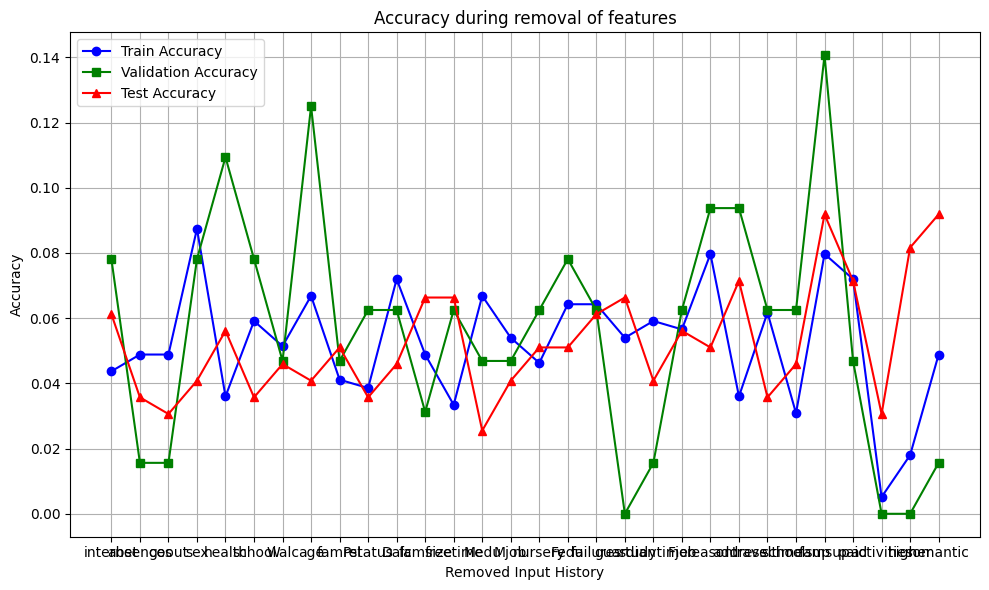

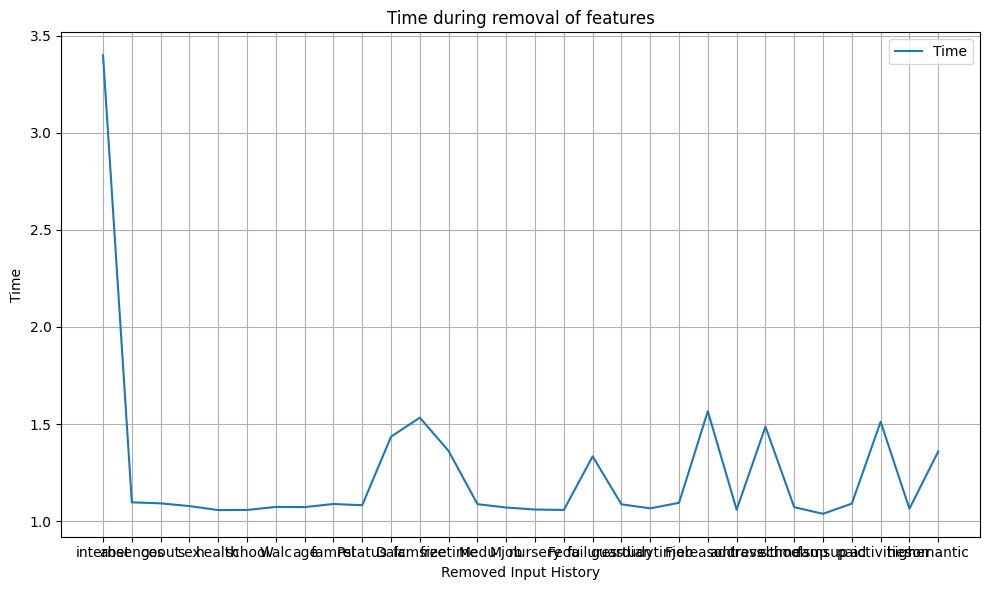

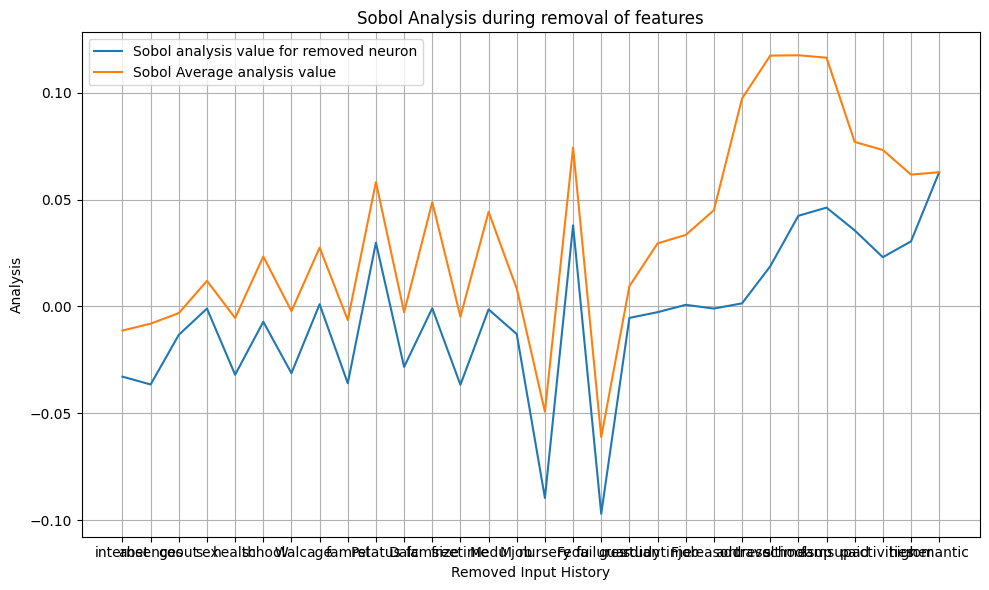

In [ ]:
print("removed_inputs_history:")
print(removed_inputs_history_first_sobol)
print("train_accuracy_history:")
print(train_accuracy_history_first_sobol)
print("valid_accuracy_history:")
print(valid_accuracy_history_first_sobol)
print("test_accuracy_history:")
print(test_accuracy_history_first_sobol)
print("time_history:")
print(time_history_first_sobol)
plot_accuracy(removed_inputs_history_first_sobol, train_accuracy_history_first_sobol, valid_accuracy_history_first_sobol, test_accuracy_history_first_sobol)
plot_time(removed_inputs_history_first_sobol, time_history_first_sobol)
plot_analysis(removed_inputs_history_first_sobol, analysis_history_first_sobol, average_analysis_history_first_sobol, "Sobol")

# Usuwanie neuronów z drugiej warstwy - SOBOL


In [ ]:
#droping useless inputs
X_copy = X.drop('higher', axis=1)
X_copy = X.drop('health', axis=1)
y_copy = y.copy()

hidden_dim = 100
removed_inputs_history_second_sobol, train_accuracy_history_second_sobol, valid_accuracy_history_second_sobol, test_accuracy_history_second_sobol, time_history_second_sobol, analysis_history_second_sobol, average_analysis_history_second_sobol = trainWhileRemovingInputsBasedOnAnalysisForSecondLayer(X_copy, y_copy, hidden_dim, AnalysisMethod.SOBOL)

---------------------------------------- Iteration 1 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 25.7176, Training Accuracy: 0.0308, Valid Accuracy: 0.1250, Test Accuracy: 0.0714
[Sobol] Dropping neuron with index 95 |  Sobol value =  -0.01129 | Avg Sobol value: 0.00955

---------------------------------------- Iteration 2 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 25.6211, Training Accuracy: 0.0463, Valid Accuracy: 0.0312, Test Accuracy: 0.0561
[Sobol] Dropping neuron with index 30 |  Sobol value =  -0.00628 | Avg Sobol value: 0.00673

---------------------------------------- Iteration 3 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 25.8057, Training Accuracy: 0.0566, Valid Accuracy: 0.0625, Test Accuracy: 0.0255
[Sobol] Dropping neuron with index 82 |  Sobol value =  -0.01723 | Avg Sobol value: 0.00058

---------------------------------------- Iteration 4 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 26.3382, Training Accuracy: 0.0334, Valid Accuracy: 0.0312, Test Accuracy: 0.0306
[Sobol] Dropping neuron with index 74 |  Sobol value =  -0.02012 | Avg Sobol value: 0.00500

---------------------------------------- Iteration 5 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 29.8556, Training Accuracy: 0.1260, Valid Accuracy: 0.0938, Test Accuracy: 0.0816
[Sobol] Dropping neuron with index 43 |  Sobol value =  -0.02537 | Avg Sobol value: 0.00317

---------------------------------------- Iteration 6 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 29.4689, Training Accuracy: 0.0566, Valid Accuracy: 0.0312, Test Accuracy: 0.0459
[Sobol] Dropping neuron with index 19 |  Sobol value =  -0.01924 | Avg Sobol value: 0.00401

---------------------------------------- Iteration 7 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 26.5002, Training Accuracy: 0.0514, Valid Accuracy: 0.0469, Test Accuracy: 0.0561
[Sobol] Dropping neuron with index 47 |  Sobol value =  -0.00576 | Avg Sobol value: 0.01126

---------------------------------------- Iteration 8 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 28.9575, Training Accuracy: 0.0514, Valid Accuracy: 0.0781, Test Accuracy: 0.0408
[Sobol] Dropping neuron with index 87 |  Sobol value =  -0.11406 | Avg Sobol value: -0.09283

---------------------------------------- Iteration 9 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 30.4473, Training Accuracy: 0.0103, Valid Accuracy: 0.0156, Test Accuracy: 0.0204
[Sobol] Dropping neuron with index 26 |  Sobol value =  -0.02882 | Avg Sobol value: -0.00546

---------------------------------------- Iteration 10 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 32.0362, Training Accuracy: 0.0308, Valid Accuracy: 0.0156, Test Accuracy: 0.0306
[Sobol] Dropping neuron with index 54 |  Sobol value =  -0.01863 | Avg Sobol value: 0.00032

---------------------------------------- Iteration 11 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 31.4458, Training Accuracy: 0.0386, Valid Accuracy: 0.0156, Test Accuracy: 0.0204
[Sobol] Dropping neuron with index 74 |  Sobol value =  -0.02168 | Avg Sobol value: 0.00186

---------------------------------------- Iteration 12 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 32.4489, Training Accuracy: 0.1028, Valid Accuracy: 0.0312, Test Accuracy: 0.1020
[Sobol] Dropping neuron with index 17 |  Sobol value =  -0.01777 | Avg Sobol value: 0.01452

---------------------------------------- Iteration 13 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 32.3719, Training Accuracy: 0.0437, Valid Accuracy: 0.0312, Test Accuracy: 0.0663
[Sobol] Dropping neuron with index 81 |  Sobol value =  -0.01008 | Avg Sobol value: 0.01363

---------------------------------------- Iteration 14 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 34.4729, Training Accuracy: 0.0617, Valid Accuracy: 0.0625, Test Accuracy: 0.0153
[Sobol] Dropping neuron with index 59 |  Sobol value =  -0.00823 | Avg Sobol value: 0.00402

---------------------------------------- Iteration 15 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 33.4955, Training Accuracy: 0.0231, Valid Accuracy: 0.0625, Test Accuracy: 0.0255
[Sobol] Dropping neuron with index 33 |  Sobol value =  0.00098 | Avg Sobol value: 0.02223

---------------------------------------- Iteration 16 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 36.7254, Training Accuracy: 0.0591, Valid Accuracy: 0.0781, Test Accuracy: 0.1071
[Sobol] Dropping neuron with index 70 |  Sobol value =  -0.02030 | Avg Sobol value: 0.00384

---------------------------------------- Iteration 17 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 34.4751, Training Accuracy: 0.0643, Valid Accuracy: 0.0000, Test Accuracy: 0.0459
[Sobol] Dropping neuron with index 34 |  Sobol value =  -0.18454 | Avg Sobol value: -0.06691

---------------------------------------- Iteration 18 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 38.9107, Training Accuracy: 0.0257, Valid Accuracy: 0.0469, Test Accuracy: 0.0255
[Sobol] Dropping neuron with index 27 |  Sobol value =  -0.00807 | Avg Sobol value: 0.01454

---------------------------------------- Iteration 19 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 38.7601, Training Accuracy: 0.0848, Valid Accuracy: 0.0469, Test Accuracy: 0.1122
[Sobol] Dropping neuron with index 76 |  Sobol value =  -0.00583 | Avg Sobol value: 0.01586

---------------------------------------- Iteration 20 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 38.0942, Training Accuracy: 0.1054, Valid Accuracy: 0.0781, Test Accuracy: 0.0663
[Sobol] Dropping neuron with index 24 |  Sobol value =  -0.03430 | Avg Sobol value: 0.00756

---------------------------------------- Iteration 21 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 42.4764, Training Accuracy: 0.0591, Valid Accuracy: 0.1562, Test Accuracy: 0.0969
[Sobol] Dropping neuron with index 39 |  Sobol value =  -0.02319 | Avg Sobol value: 0.00314

---------------------------------------- Iteration 22 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 41.4175, Training Accuracy: 0.0668, Valid Accuracy: 0.0781, Test Accuracy: 0.1020
[Sobol] Dropping neuron with index 52 |  Sobol value =  -0.02335 | Avg Sobol value: -0.00137

---------------------------------------- Iteration 23 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 40.4302, Training Accuracy: 0.0411, Valid Accuracy: 0.0625, Test Accuracy: 0.0306
[Sobol] Dropping neuron with index 0 |  Sobol value =  -0.02791 | Avg Sobol value: -0.00317

---------------------------------------- Iteration 24 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 40.9266, Training Accuracy: 0.0386, Valid Accuracy: 0.0625, Test Accuracy: 0.0612
[Sobol] Dropping neuron with index 71 |  Sobol value =  -0.00776 | Avg Sobol value: 0.02145

---------------------------------------- Iteration 25 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 41.7147, Training Accuracy: 0.0591, Valid Accuracy: 0.0781, Test Accuracy: 0.0306
[Sobol] Dropping neuron with index 51 |  Sobol value =  -0.12446 | Avg Sobol value: -0.09866

---------------------------------------- Iteration 26 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 43.8222, Training Accuracy: 0.0925, Valid Accuracy: 0.0469, Test Accuracy: 0.0969
[Sobol] Dropping neuron with index 12 |  Sobol value =  -0.00907 | Avg Sobol value: 0.02895

---------------------------------------- Iteration 27 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 45.9040, Training Accuracy: 0.0746, Valid Accuracy: 0.0781, Test Accuracy: 0.0765
[Sobol] Dropping neuron with index 55 |  Sobol value =  0.00324 | Avg Sobol value: 0.02984

---------------------------------------- Iteration 28 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 44.6970, Training Accuracy: 0.0694, Valid Accuracy: 0.0781, Test Accuracy: 0.0714
[Sobol] Dropping neuron with index 66 |  Sobol value =  -0.02335 | Avg Sobol value: -0.00296

---------------------------------------- Iteration 29 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 48.2605, Training Accuracy: 0.0360, Valid Accuracy: 0.0156, Test Accuracy: 0.0306
[Sobol] Dropping neuron with index 71 |  Sobol value =  -0.02778 | Avg Sobol value: 0.00894

---------------------------------------- Iteration 30 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 46.4444, Training Accuracy: 0.0206, Valid Accuracy: 0.0625, Test Accuracy: 0.0255
[Sobol] Dropping neuron with index 56 |  Sobol value =  -0.01802 | Avg Sobol value: 0.00803

---------------------------------------- Iteration 31 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 48.0500, Training Accuracy: 0.0308, Valid Accuracy: 0.0156, Test Accuracy: 0.0204
[Sobol] Dropping neuron with index 42 |  Sobol value =  -0.01833 | Avg Sobol value: 0.01375

---------------------------------------- Iteration 32 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 51.9941, Training Accuracy: 0.0925, Valid Accuracy: 0.1094, Test Accuracy: 0.0918
[Sobol] Dropping neuron with index 10 |  Sobol value =  -0.05396 | Avg Sobol value: -0.00367

---------------------------------------- Iteration 33 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 50.9632, Training Accuracy: 0.0694, Valid Accuracy: 0.1250, Test Accuracy: 0.0561
[Sobol] Dropping neuron with index 48 |  Sobol value =  -0.03199 | Avg Sobol value: 0.00008

---------------------------------------- Iteration 34 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 51.9032, Training Accuracy: 0.0206, Valid Accuracy: 0.0312, Test Accuracy: 0.0204
[Sobol] Dropping neuron with index 43 |  Sobol value =  -0.09864 | Avg Sobol value: -0.04005

---------------------------------------- Iteration 35 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 53.1850, Training Accuracy: 0.0720, Valid Accuracy: 0.0781, Test Accuracy: 0.0459
[Sobol] Dropping neuron with index 31 |  Sobol value =  -0.01273 | Avg Sobol value: 0.00434

---------------------------------------- Iteration 36 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 54.4487, Training Accuracy: 0.0257, Valid Accuracy: 0.0156, Test Accuracy: 0.0357
[Sobol] Dropping neuron with index 24 |  Sobol value =  -0.02276 | Avg Sobol value: 0.00343

---------------------------------------- Iteration 37 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 53.9677, Training Accuracy: 0.0437, Valid Accuracy: 0.0156, Test Accuracy: 0.0714
[Sobol] Dropping neuron with index 56 |  Sobol value =  -0.05877 | Avg Sobol value: -0.02511

---------------------------------------- Iteration 38 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 53.9177, Training Accuracy: 0.0283, Valid Accuracy: 0.0000, Test Accuracy: 0.0306
[Sobol] Dropping neuron with index 12 |  Sobol value =  -0.01247 | Avg Sobol value: 0.00730

---------------------------------------- Iteration 39 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 57.2317, Training Accuracy: 0.0643, Valid Accuracy: 0.0469, Test Accuracy: 0.0510
[Sobol] Dropping neuron with index 32 |  Sobol value =  -0.00783 | Avg Sobol value: 0.01395

---------------------------------------- Iteration 40 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 57.0824, Training Accuracy: 0.0386, Valid Accuracy: 0.0312, Test Accuracy: 0.0204
[Sobol] Dropping neuron with index 30 |  Sobol value =  -0.05398 | Avg Sobol value: -0.00963

---------------------------------------- Iteration 41 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 59.5910, Training Accuracy: 0.0951, Valid Accuracy: 0.0938, Test Accuracy: 0.0663
[Sobol] Dropping neuron with index 24 |  Sobol value =  -0.01205 | Avg Sobol value: 0.00752

---------------------------------------- Iteration 42 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 60.9319, Training Accuracy: 0.0231, Valid Accuracy: 0.0156, Test Accuracy: 0.0204
[Sobol] Dropping neuron with index 58 |  Sobol value =  -0.18296 | Avg Sobol value: -0.14171

---------------------------------------- Iteration 43 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 58.4200, Training Accuracy: 0.0540, Valid Accuracy: 0.0469, Test Accuracy: 0.0714
[Sobol] Dropping neuron with index 21 |  Sobol value =  -0.01357 | Avg Sobol value: 0.02171

---------------------------------------- Iteration 44 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 60.8720, Training Accuracy: 0.0180, Valid Accuracy: 0.0000, Test Accuracy: 0.0255
[Sobol] Dropping neuron with index 22 |  Sobol value =  -0.02867 | Avg Sobol value: 0.00573

---------------------------------------- Iteration 45 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 64.3692, Training Accuracy: 0.0283, Valid Accuracy: 0.0312, Test Accuracy: 0.0357
[Sobol] Dropping neuron with index 1 |  Sobol value =  -0.04312 | Avg Sobol value: -0.00596

---------------------------------------- Iteration 46 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 65.5548, Training Accuracy: 0.0411, Valid Accuracy: 0.0469, Test Accuracy: 0.0255


In [ ]:
print("removed_inputs_history:")
print(removed_inputs_history_second_sobol)
print("train_accuracy_history:")n
print(train_accuracy_history_second_sobol)
print("valid_accuracy_history:")
print(valid_accuracy_history_second_sobol)
print("test_accuracy_history:")
print(test_accuracy_history_second_sobol)
print("time_history:")
print(time_history_second_sobol)
plot_accuracy(None, train_accuracy_history_second_sobol, valid_accuracy_history_second_sobol, test_accuracy_history_second_sobol)
plot_time(None, time_history_second_sobol)
plot_analysis(None, analysis_history_second_sobol, average_analysis_history_second_sobol, "Sobol")

## Ewaluacja

In [ ]:
# epochs = np.arange(0, len(train_losses))
# plt.plot(epochs, np.array(train_losses), 'b', label='train MSE loss')
# plt.plot(epochs, np.array(val_losses), 'r', label='val MSE loss')

# plt.title(f'Model learning curve')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


In [ ]:
# model.eval()
# with torch.no_grad():
#   test_predict = model(X_test_tensor)
#   test_mse = mean_squared_error(y_test, test_predict)
#   print(f"Test MSE = {test_mse:.3f}")

# Usuwanie neuronów z pierwszej warstwy - PAWN

In [ ]:
#droping useless inputs
hidden_dim = 100
removed_inputs_history_first_pawn, train_accuracy_history_first_pawn, valid_accuracy_history_first_pawn, test_accuracy_history_first_pawn, time_history_first_pawn, analysis_history_first_pawn, average_analysis_history_first_pawn = trainWhileRemovingInputsBasedOnAnalysisForFirstLayer(X, y, hidden_dim, AnalysisMethod.PAWN)

---------------------------------------- Iteration 1 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.0876, Training Accuracy: 0.0643, Valid Accuracy: 0.0156, , Test Accuracy: 0.0510
[PAWN] Dropping neuron with index 16 (column: famsup) |  PAWN value =  0.29284 | Avg PAWN value: 0.04538 

---------------------------------------- Iteration 2 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.0846, Training Accuracy: 0.0566, Valid Accuracy: 0.0469, , Test Accuracy: 0.0561
[PAWN] Dropping neuron with index 0 (column: school) |  PAWN value =  0.24535 | Avg PAWN value: 0.04827 

---------------------------------------- Iteration 3 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.0766, Training Accuracy: 0.0643, Valid Accuracy: 0.0469, , Test Accuracy: 0.0510
[PAWN] Dropping neuron with index 19 (column: internet) |  PAWN value =  0.37672 | Avg PAWN value: 0.04363 

---------------------------------------- Iteration 4 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.0907, Training Accuracy: 0.0488, Valid Accuracy: 0.1094, , Test Accuracy: 0.0561
[PAWN] Dropping neuron with index 8 (column: Fjob) |  PAWN value =  0.45818 | Avg PAWN value: 0.05012 

---------------------------------------- Iteration 5 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.0812, Training Accuracy: 0.0694, Valid Accuracy: 0.0625, , Test Accuracy: 0.0714
[PAWN] Dropping neuron with index 23 (column: Walc) |  PAWN value =  0.48168 | Avg PAWN value: 0.04383 

---------------------------------------- Iteration 6 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.1717, Training Accuracy: 0.0694, Valid Accuracy: 0.0156, , Test Accuracy: 0.0459
[PAWN] Dropping neuron with index 19 (column: famrel) |  PAWN value =  0.39053 | Avg PAWN value: 0.04583 

---------------------------------------- Iteration 7 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.1344, Training Accuracy: 0.0463, Valid Accuracy: 0.0781, , Test Accuracy: 0.0765
[PAWN] Dropping neuron with index 20 (column: goout) |  PAWN value =  0.37162 | Avg PAWN value: 0.04831 

---------------------------------------- Iteration 8 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.1351, Training Accuracy: 0.0514, Valid Accuracy: 0.0000, , Test Accuracy: 0.0765
[PAWN] Dropping neuron with index 0 (column: sex) |  PAWN value =  0.27712 | Avg PAWN value: 0.04806 

---------------------------------------- Iteration 9 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.1319, Training Accuracy: 0.0694, Valid Accuracy: 0.0625, , Test Accuracy: 0.0561
[PAWN] Dropping neuron with index 20 (column: health) |  PAWN value =  0.36172 | Avg PAWN value: 0.05012 

---------------------------------------- Iteration 10 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.1079, Training Accuracy: 0.0797, Valid Accuracy: 0.0938, , Test Accuracy: 0.0510
[PAWN] Dropping neuron with index 15 (column: nursery) |  PAWN value =  0.45183 | Avg PAWN value: 0.04754 

---------------------------------------- Iteration 11 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.1032, Training Accuracy: 0.0540, Valid Accuracy: 0.0469, , Test Accuracy: 0.0408
[PAWN] Dropping neuron with index 6 (column: Mjob) |  PAWN value =  0.46735 | Avg PAWN value: 0.05241 

---------------------------------------- Iteration 12 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.3008, Training Accuracy: 0.0488, Valid Accuracy: 0.1094, , Test Accuracy: 0.0408
[PAWN] Dropping neuron with index 15 (column: romantic) |  PAWN value =  0.47857 | Avg PAWN value: 0.04786 

---------------------------------------- Iteration 13 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.1393, Training Accuracy: 0.0360, Valid Accuracy: 0.0000, , Test Accuracy: 0.0306
[PAWN] Dropping neuron with index 9 (column: studytime) |  PAWN value =  0.45627 | Avg PAWN value: 0.04977 

---------------------------------------- Iteration 14 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.1695, Training Accuracy: 0.0514, Valid Accuracy: 0.0469, , Test Accuracy: 0.0408
[PAWN] Dropping neuron with index 6 (column: reason) |  PAWN value =  0.27470 | Avg PAWN value: 0.05332 

---------------------------------------- Iteration 15 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.2578, Training Accuracy: 0.0591, Valid Accuracy: 0.0625, , Test Accuracy: 0.0561
[PAWN] Dropping neuron with index 2 (column: famsize) |  PAWN value =  0.47255 | Avg PAWN value: 0.04894 

---------------------------------------- Iteration 16 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.4502, Training Accuracy: 0.0514, Valid Accuracy: 0.0938, , Test Accuracy: 0.0714
[PAWN] Dropping neuron with index 11 (column: higher) |  PAWN value =  0.43091 | Avg PAWN value: 0.05434 

---------------------------------------- Iteration 17 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.6446, Training Accuracy: 0.0540, Valid Accuracy: 0.0469, , Test Accuracy: 0.0765
[PAWN] Dropping neuron with index 3 (column: Medu) |  PAWN value =  0.40329 | Avg PAWN value: 0.05744 

---------------------------------------- Iteration 18 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.8815, Training Accuracy: 0.0334, Valid Accuracy: 0.0469, , Test Accuracy: 0.0306
[PAWN] Dropping neuron with index 1 (column: address) |  PAWN value =  0.34682 | Avg PAWN value: 0.06153 

---------------------------------------- Iteration 19 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.9448, Training Accuracy: 0.0463, Valid Accuracy: 0.0625, , Test Accuracy: 0.0306
[PAWN] Dropping neuron with index 1 (column: Pstatus) |  PAWN value =  0.40702 | Avg PAWN value: 0.06003 

---------------------------------------- Iteration 20 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 1.3643, Training Accuracy: 0.0437, Valid Accuracy: 0.0156, , Test Accuracy: 0.0714
[PAWN] Dropping neuron with index 2 (column: guardian) |  PAWN value =  0.27286 | Avg PAWN value: 0.06882 

---------------------------------------- Iteration 21 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 1.3018, Training Accuracy: 0.0591, Valid Accuracy: 0.0156, , Test Accuracy: 0.0459
[PAWN] Dropping neuron with index 4 (column: schoolsup) |  PAWN value =  0.41972 | Avg PAWN value: 0.06880 

---------------------------------------- Iteration 22 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 1.8316, Training Accuracy: 0.0746, Valid Accuracy: 0.0625, , Test Accuracy: 0.0561
[PAWN] Dropping neuron with index 2 (column: traveltime) |  PAWN value =  0.64408 | Avg PAWN value: 0.07203 

---------------------------------------- Iteration 23 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 2.3994, Training Accuracy: 0.0308, Valid Accuracy: 0.0938, , Test Accuracy: 0.0714
[PAWN] Dropping neuron with index 0 (column: age) |  PAWN value =  0.38546 | Avg PAWN value: 0.06343 

---------------------------------------- Iteration 24 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 2.0488, Training Accuracy: 0.0617, Valid Accuracy: 0.0312, , Test Accuracy: 0.0561
[PAWN] Dropping neuron with index 0 (column: Fedu) |  PAWN value =  0.29652 | Avg PAWN value: 0.09337 

---------------------------------------- Iteration 25 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 2.8038, Training Accuracy: 0.0411, Valid Accuracy: 0.0312, , Test Accuracy: 0.0561
[PAWN] Dropping neuron with index 3 (column: freetime) |  PAWN value =  0.23704 | Avg PAWN value: 0.11965 

---------------------------------------- Iteration 26 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 3.2350, Training Accuracy: 0.0308, Valid Accuracy: 0.0938, , Test Accuracy: 0.0510
[PAWN] Dropping neuron with index 4 (column: absences) |  PAWN value =  0.36476 | Avg PAWN value: 0.10522 

---------------------------------------- Iteration 27 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 4.2056, Training Accuracy: 0.0154, Valid Accuracy: 0.0938, , Test Accuracy: 0.0051
[PAWN] Dropping neuron with index 0 (column: failures) |  PAWN value =  0.51424 | Avg PAWN value: 0.12379 

---------------------------------------- Iteration 28 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 9.8447, Training Accuracy: 0.0386, Valid Accuracy: 0.0938, , Test Accuracy: 0.0663
[PAWN] Dropping neuron with index 2 (column: Dalc) |  PAWN value =  0.36456 | Avg PAWN value: 0.19892 

---------------------------------------- Iteration 29 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 10.8867, Training Accuracy: 0.0026, Valid Accuracy: 0.0000, , Test Accuracy: 0.0051
[PAWN] Dropping neuron with index 0 (column: paid) |  PAWN value =  0.27934 | Avg PAWN value: 0.29556 

---------------------------------------- Iteration 30 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 11.5929, Training Accuracy: 0.0720, Valid Accuracy: 0.0156, , Test Accuracy: 0.0612
[PAWN] Dropping neuron with index 0 (column: activities) |  PAWN value =  0.24268 | Avg PAWN value: 0.53613 



removed_inputs_history:
['famsup', 'school', 'internet', 'Fjob', 'Walc', 'famrel', 'goout', 'sex', 'health', 'nursery', 'Mjob', 'romantic', 'studytime', 'reason', 'famsize', 'higher', 'Medu', 'address', 'Pstatus', 'guardian', 'schoolsup', 'traveltime', 'age', 'Fedu', 'freetime', 'absences', 'failures', 'Dalc', 'paid', 'activities']
train_accuracy_history:
[0.06426735218508997, 0.056555269922879174, 0.06426735218508997, 0.04884318766066838, 0.06940874035989718, 0.06940874035989718, 0.04627249357326478, 0.05141388174807198, 0.06940874035989718, 0.07969151670951156, 0.05398457583547558, 0.04884318766066838, 0.03598971722365039, 0.05141388174807198, 0.05912596401028278, 0.05141388174807198, 0.05398457583547558, 0.033419023136246784, 0.04627249357326478, 0.043701799485861184, 0.05912596401028278, 0.07455012853470437, 0.030848329048843187, 0.061696658097686374, 0.04113110539845758, 0.030848329048843187, 0.015424164524421594, 0.038560411311053984, 0.002570694087403599, 0.07197943444730077]
va

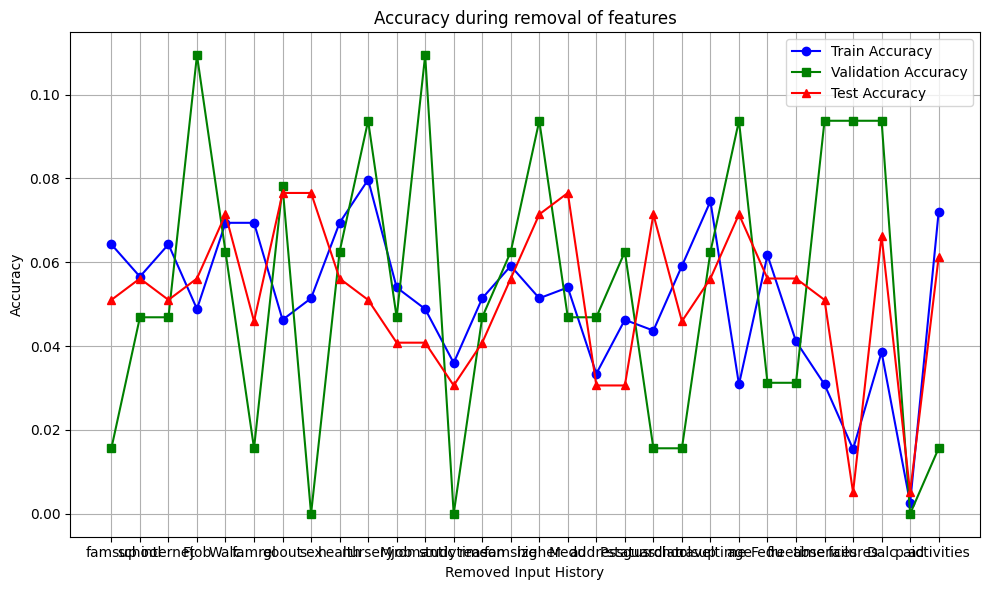

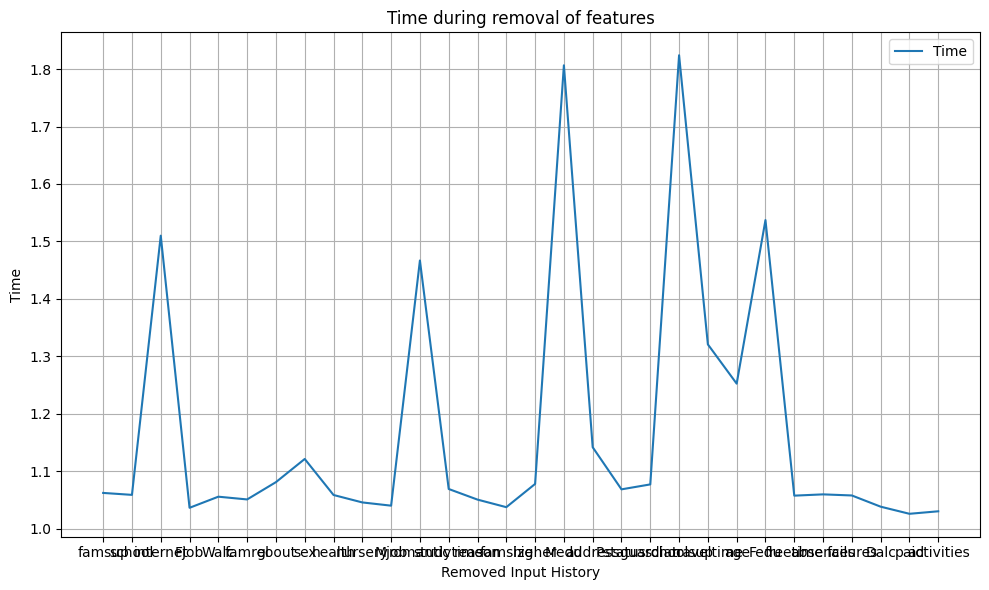

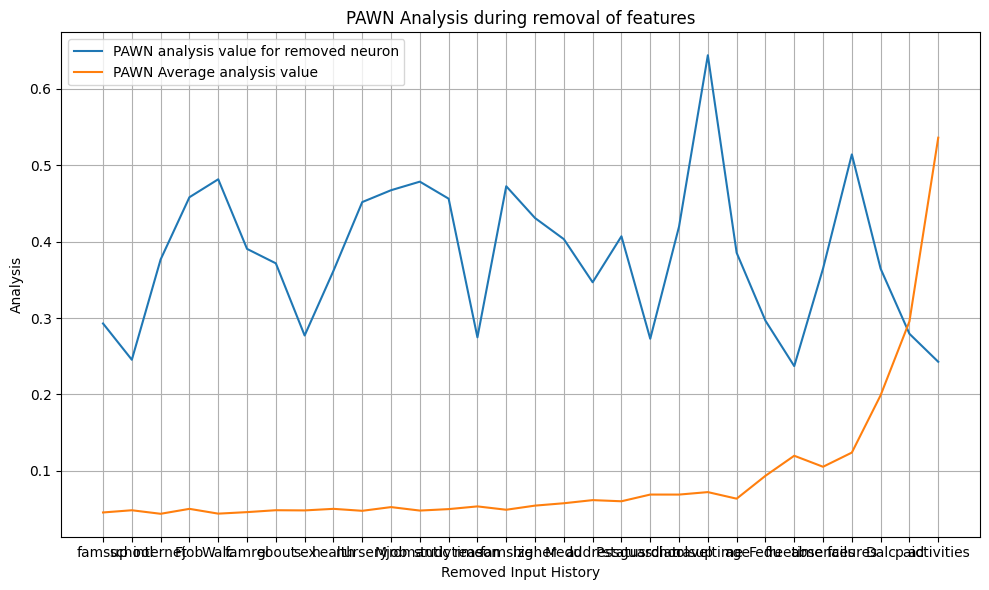

In [ ]:
print("removed_inputs_history:")
print(removed_inputs_history_first_pawn)
print("train_accuracy_history:")
print(train_accuracy_history_first_pawn)
print("valid_accuracy_history:")
print(valid_accuracy_history_first_pawn)
print("test_accuracy_history:")
print(test_accuracy_history_first_pawn)
print("time_history:")
print(time_history_first_pawn)
plot_accuracy(removed_inputs_history_first_pawn, train_accuracy_history_first_pawn, valid_accuracy_history_first_pawn, test_accuracy_history_first_pawn)
plot_time(removed_inputs_history_first_pawn, time_history_first_pawn)
plot_analysis(removed_inputs_history_first_pawn, analysis_history_first_pawn, average_analysis_history_first_pawn, "PAWN")

# Usuwanie neuronów z drugiej warstwy - PAWN

In [ ]:
#droping useless inputs
X_copy = X.drop('Pstatus', axis=1)
X_copy = X.drop('school', axis=1)
y_copy = y.copy()

hidden_dim = 100

removed_inputs_history_second_pawn, train_accuracy_history_second_pawn, valid_accuracy_history_second_pawn, test_accuracy_history_second_pawn, time_history_second_pawn, analysis_history_second_pawn, average_analysis_history_second_pawn = trainWhileRemovingInputsBasedOnAnalysisForSecondLayer(X_copy, y_copy, hidden_dim, AnalysisMethod.PAWN)

---------------------------------------- Iteration 1 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 24.8221, Training Accuracy: 0.0591, Valid Accuracy: 0.1250, Test Accuracy: 0.0459
[PAWN] Dropping neuron with index 6 |  PAWN value =  0.03111 | Avg PAWN value: 0.04661 

---------------------------------------- Iteration 2 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 26.3081, Training Accuracy: 0.0308, Valid Accuracy: 0.0625, Test Accuracy: 0.0408
[PAWN] Dropping neuron with index 62 |  PAWN value =  0.02849 | Avg PAWN value: 0.04632 

---------------------------------------- Iteration 3 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 26.6539, Training Accuracy: 0.0617, Valid Accuracy: 0.0625, Test Accuracy: 0.0459
[PAWN] Dropping neuron with index 81 |  PAWN value =  0.02930 | Avg PAWN value: 0.04531 

---------------------------------------- Iteration 4 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 30.0318, Training Accuracy: 0.0257, Valid Accuracy: 0.0156, Test Accuracy: 0.0459
[PAWN] Dropping neuron with index 78 |  PAWN value =  0.03005 | Avg PAWN value: 0.04602 

---------------------------------------- Iteration 5 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 26.9422, Training Accuracy: 0.0900, Valid Accuracy: 0.0312, Test Accuracy: 0.0714
[PAWN] Dropping neuron with index 84 |  PAWN value =  0.02514 | Avg PAWN value: 0.04527 

---------------------------------------- Iteration 6 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 29.5191, Training Accuracy: 0.0463, Valid Accuracy: 0.0469, Test Accuracy: 0.0561
[PAWN] Dropping neuron with index 93 |  PAWN value =  0.02989 | Avg PAWN value: 0.04602 

---------------------------------------- Iteration 7 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 28.9851, Training Accuracy: 0.0360, Valid Accuracy: 0.0000, Test Accuracy: 0.0357
[PAWN] Dropping neuron with index 36 |  PAWN value =  0.03035 | Avg PAWN value: 0.04715 

---------------------------------------- Iteration 8 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 30.3515, Training Accuracy: 0.0360, Valid Accuracy: 0.0156, Test Accuracy: 0.0357
[PAWN] Dropping neuron with index 22 |  PAWN value =  0.02931 | Avg PAWN value: 0.04779 

---------------------------------------- Iteration 9 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 31.1680, Training Accuracy: 0.0386, Valid Accuracy: 0.1250, Test Accuracy: 0.0408
[PAWN] Dropping neuron with index 50 |  PAWN value =  0.02738 | Avg PAWN value: 0.04611 

---------------------------------------- Iteration 10 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 31.2950, Training Accuracy: 0.0334, Valid Accuracy: 0.0312, Test Accuracy: 0.0255
[PAWN] Dropping neuron with index 45 |  PAWN value =  0.02650 | Avg PAWN value: 0.04676 

---------------------------------------- Iteration 11 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 31.7419, Training Accuracy: 0.1105, Valid Accuracy: 0.0938, Test Accuracy: 0.0561
[PAWN] Dropping neuron with index 15 |  PAWN value =  0.02529 | Avg PAWN value: 0.04358 

---------------------------------------- Iteration 12 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 33.2896, Training Accuracy: 0.0463, Valid Accuracy: 0.0469, Test Accuracy: 0.0408
[PAWN] Dropping neuron with index 49 |  PAWN value =  0.02696 | Avg PAWN value: 0.04644 

---------------------------------------- Iteration 13 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 32.7573, Training Accuracy: 0.0643, Valid Accuracy: 0.0625, Test Accuracy: 0.0561
[PAWN] Dropping neuron with index 71 |  PAWN value =  0.02799 | Avg PAWN value: 0.04653 

---------------------------------------- Iteration 14 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 32.2881, Training Accuracy: 0.0617, Valid Accuracy: 0.0469, Test Accuracy: 0.0408
[PAWN] Dropping neuron with index 84 |  PAWN value =  0.03135 | Avg PAWN value: 0.04872 

---------------------------------------- Iteration 15 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 31.7426, Training Accuracy: 0.0231, Valid Accuracy: 0.0312, Test Accuracy: 0.0357
[PAWN] Dropping neuron with index 28 |  PAWN value =  0.02580 | Avg PAWN value: 0.04552 

---------------------------------------- Iteration 16 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 35.0293, Training Accuracy: 0.0283, Valid Accuracy: 0.0469, Test Accuracy: 0.0459
[PAWN] Dropping neuron with index 42 |  PAWN value =  0.02603 | Avg PAWN value: 0.04648 

---------------------------------------- Iteration 17 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 37.6883, Training Accuracy: 0.0334, Valid Accuracy: 0.0781, Test Accuracy: 0.0357
[PAWN] Dropping neuron with index 40 |  PAWN value =  0.02969 | Avg PAWN value: 0.04718 

---------------------------------------- Iteration 18 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 35.8785, Training Accuracy: 0.0720, Valid Accuracy: 0.0625, Test Accuracy: 0.0969
[PAWN] Dropping neuron with index 28 |  PAWN value =  0.03211 | Avg PAWN value: 0.04753 

---------------------------------------- Iteration 19 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 37.3007, Training Accuracy: 0.0720, Valid Accuracy: 0.0625, Test Accuracy: 0.0714
[PAWN] Dropping neuron with index 52 |  PAWN value =  0.02998 | Avg PAWN value: 0.04929 

---------------------------------------- Iteration 20 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 39.0640, Training Accuracy: 0.0643, Valid Accuracy: 0.1719, Test Accuracy: 0.0612
[PAWN] Dropping neuron with index 0 |  PAWN value =  0.02982 | Avg PAWN value: 0.04760 

---------------------------------------- Iteration 21 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 39.1362, Training Accuracy: 0.1131, Valid Accuracy: 0.0625, Test Accuracy: 0.0816
[PAWN] Dropping neuron with index 20 |  PAWN value =  0.02851 | Avg PAWN value: 0.04809 

---------------------------------------- Iteration 22 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 40.3322, Training Accuracy: 0.0386, Valid Accuracy: 0.0781, Test Accuracy: 0.0510
[PAWN] Dropping neuron with index 45 |  PAWN value =  0.02882 | Avg PAWN value: 0.05044 

---------------------------------------- Iteration 23 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 42.1991, Training Accuracy: 0.0231, Valid Accuracy: 0.0469, Test Accuracy: 0.0153
[PAWN] Dropping neuron with index 7 |  PAWN value =  0.03207 | Avg PAWN value: 0.04923 

---------------------------------------- Iteration 24 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 43.7948, Training Accuracy: 0.0617, Valid Accuracy: 0.0156, Test Accuracy: 0.0255
[PAWN] Dropping neuron with index 31 |  PAWN value =  0.02999 | Avg PAWN value: 0.04937 

---------------------------------------- Iteration 25 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 43.0836, Training Accuracy: 0.0797, Valid Accuracy: 0.0625, Test Accuracy: 0.0714
[PAWN] Dropping neuron with index 7 |  PAWN value =  0.02751 | Avg PAWN value: 0.04862 

---------------------------------------- Iteration 26 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 43.7672, Training Accuracy: 0.0206, Valid Accuracy: 0.0000, Test Accuracy: 0.0204
[PAWN] Dropping neuron with index 37 |  PAWN value =  0.03046 | Avg PAWN value: 0.04759 

---------------------------------------- Iteration 27 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 43.7809, Training Accuracy: 0.0668, Valid Accuracy: 0.0000, Test Accuracy: 0.0714
[PAWN] Dropping neuron with index 27 |  PAWN value =  0.01446 | Avg PAWN value: 0.02797 

---------------------------------------- Iteration 28 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 46.4164, Training Accuracy: 0.0823, Valid Accuracy: 0.0312, Test Accuracy: 0.0765
[PAWN] Dropping neuron with index 44 |  PAWN value =  0.03117 | Avg PAWN value: 0.05034 

---------------------------------------- Iteration 29 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 45.3449, Training Accuracy: 0.0617, Valid Accuracy: 0.0312, Test Accuracy: 0.0357
[PAWN] Dropping neuron with index 53 |  PAWN value =  0.03062 | Avg PAWN value: 0.04653 

---------------------------------------- Iteration 30 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 46.7291, Training Accuracy: 0.0591, Valid Accuracy: 0.0312, Test Accuracy: 0.1122
[PAWN] Dropping neuron with index 62 |  PAWN value =  0.03118 | Avg PAWN value: 0.05178 

---------------------------------------- Iteration 31 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 49.3228, Training Accuracy: 0.0360, Valid Accuracy: 0.0469, Test Accuracy: 0.0255
[PAWN] Dropping neuron with index 6 |  PAWN value =  0.02957 | Avg PAWN value: 0.04731 

---------------------------------------- Iteration 32 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 52.1442, Training Accuracy: 0.0591, Valid Accuracy: 0.0312, Test Accuracy: 0.0204
[PAWN] Dropping neuron with index 42 |  PAWN value =  0.02910 | Avg PAWN value: 0.04823 

---------------------------------------- Iteration 33 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 49.7888, Training Accuracy: 0.0874, Valid Accuracy: 0.0625, Test Accuracy: 0.0612
[PAWN] Dropping neuron with index 16 |  PAWN value =  0.02675 | Avg PAWN value: 0.05017 

---------------------------------------- Iteration 34 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 48.6311, Training Accuracy: 0.0386, Valid Accuracy: 0.0312, Test Accuracy: 0.0459
[PAWN] Dropping neuron with index 26 |  PAWN value =  0.03008 | Avg PAWN value: 0.04774 

---------------------------------------- Iteration 35 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 52.7776, Training Accuracy: 0.0540, Valid Accuracy: 0.0625, Test Accuracy: 0.0561
[PAWN] Dropping neuron with index 57 |  PAWN value =  0.03239 | Avg PAWN value: 0.04969 

---------------------------------------- Iteration 36 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 53.4499, Training Accuracy: 0.0437, Valid Accuracy: 0.0781, Test Accuracy: 0.0408
[PAWN] Dropping neuron with index 40 |  PAWN value =  0.03388 | Avg PAWN value: 0.04950 

---------------------------------------- Iteration 37 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 54.7048, Training Accuracy: 0.0231, Valid Accuracy: 0.0000, Test Accuracy: 0.0255
[PAWN] Dropping neuron with index 59 |  PAWN value =  0.02888 | Avg PAWN value: 0.04406 

---------------------------------------- Iteration 38 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 55.0502, Training Accuracy: 0.0925, Valid Accuracy: 0.0938, Test Accuracy: 0.1071
[PAWN] Dropping neuron with index 2 |  PAWN value =  0.02611 | Avg PAWN value: 0.04643 

---------------------------------------- Iteration 39 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 57.3666, Training Accuracy: 0.0668, Valid Accuracy: 0.0469, Test Accuracy: 0.0714
[PAWN] Dropping neuron with index 20 |  PAWN value =  0.03185 | Avg PAWN value: 0.05134 

---------------------------------------- Iteration 40 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 53.7077, Training Accuracy: 0.0617, Valid Accuracy: 0.0156, Test Accuracy: 0.0357
[PAWN] Dropping neuron with index 22 |  PAWN value =  0.02999 | Avg PAWN value: 0.05067 

---------------------------------------- Iteration 41 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 61.3912, Training Accuracy: 0.0257, Valid Accuracy: 0.0156, Test Accuracy: 0.0204
[PAWN] Dropping neuron with index 23 |  PAWN value =  0.02882 | Avg PAWN value: 0.04913 

---------------------------------------- Iteration 42 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 62.5262, Training Accuracy: 0.0848, Valid Accuracy: 0.1094, Test Accuracy: 0.0714
[PAWN] Dropping neuron with index 0 |  PAWN value =  0.02645 | Avg PAWN value: 0.04923 

---------------------------------------- Iteration 43 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 61.4466, Training Accuracy: 0.0797, Valid Accuracy: 0.1250, Test Accuracy: 0.0612
[PAWN] Dropping neuron with index 25 |  PAWN value =  0.03055 | Avg PAWN value: 0.05096 

---------------------------------------- Iteration 44 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 64.5436, Training Accuracy: 0.0386, Valid Accuracy: 0.0312, Test Accuracy: 0.0357
[PAWN] Dropping neuron with index 52 |  PAWN value =  0.02851 | Avg PAWN value: 0.04926 

---------------------------------------- Iteration 45 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 65.9402, Training Accuracy: 0.0257, Valid Accuracy: 0.0312, Test Accuracy: 0.0051
[PAWN] Dropping neuron with index 14 |  PAWN value =  0.02295 | Avg PAWN value: 0.04482 

---------------------------------------- Iteration 46 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 66.0759, Training Accuracy: 0.0566, Valid Accuracy: 0.1250, Test Accuracy: 0.0816
[PAWN] Dropping neuron with index 1 |  PAWN value =  0.03317 | Avg PAWN value: 0.05513 

---------------------------------------- Iteration 47 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 66.8628, Training Accuracy: 0.0643, Valid Accuracy: 0.0312, Test Accuracy: 0.0816
[PAWN] Dropping neuron with index 45 |  PAWN value =  0.03026 | Avg PAWN value: 0.05087 

---------------------------------------- Iteration 48 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 66.8239, Training Accuracy: 0.0514, Valid Accuracy: 0.0000, Test Accuracy: 0.0714
[PAWN] Dropping neuron with index 26 |  PAWN value =  0.02636 | Avg PAWN value: 0.04912 

---------------------------------------- Iteration 49 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 68.7172, Training Accuracy: 0.0488, Valid Accuracy: 0.0469, Test Accuracy: 0.0306
[PAWN] Dropping neuron with index 21 |  PAWN value =  0.02366 | Avg PAWN value: 0.04583 

---------------------------------------- Iteration 50 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 67.9818, Training Accuracy: 0.0334, Valid Accuracy: 0.0312, Test Accuracy: 0.0408
[PAWN] Dropping neuron with index 49 |  PAWN value =  0.03087 | Avg PAWN value: 0.05231 

---------------------------------------- Iteration 51 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 71.6274, Training Accuracy: 0.0566, Valid Accuracy: 0.1094, Test Accuracy: 0.0459
[PAWN] Dropping neuron with index 10 |  PAWN value =  0.02904 | Avg PAWN value: 0.05094 

---------------------------------------- Iteration 52 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 73.6292, Training Accuracy: 0.0180, Valid Accuracy: 0.0312, Test Accuracy: 0.0153
[PAWN] Dropping neuron with index 12 |  PAWN value =  0.02524 | Avg PAWN value: 0.05324 

---------------------------------------- Iteration 53 ----------------------------------------
Loss: 72.5633, Training Accuracy: 0.0694, Valid Accuracy: 0.0625, Test Accuracy: 0.0816


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[PAWN] Dropping neuron with index 1 |  PAWN value =  0.03245 | Avg PAWN value: 0.05031 

---------------------------------------- Iteration 54 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 75.3096, Training Accuracy: 0.1003, Valid Accuracy: 0.0312, Test Accuracy: 0.0867
[PAWN] Dropping neuron with index 1 |  PAWN value =  0.03072 | Avg PAWN value: 0.04898 

---------------------------------------- Iteration 55 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 80.1734, Training Accuracy: 0.1054, Valid Accuracy: 0.0000, Test Accuracy: 0.1173
[PAWN] Dropping neuron with index 27 |  PAWN value =  0.02925 | Avg PAWN value: 0.05240 

---------------------------------------- Iteration 56 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 78.3754, Training Accuracy: 0.0386, Valid Accuracy: 0.0312, Test Accuracy: 0.0561
[PAWN] Dropping neuron with index 5 |  PAWN value =  0.03216 | Avg PAWN value: 0.05444 

---------------------------------------- Iteration 57 ----------------------------------------
Loss: 81.2376, Training Accuracy: 0.0488, Valid Accuracy: 0.0938, Test Accuracy: 0.0408


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[PAWN] Dropping neuron with index 6 |  PAWN value =  0.03030 | Avg PAWN value: 0.05246 

---------------------------------------- Iteration 58 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 79.9721, Training Accuracy: 0.0746, Valid Accuracy: 0.0469, Test Accuracy: 0.0408
[PAWN] Dropping neuron with index 1 |  PAWN value =  0.03096 | Avg PAWN value: 0.05584 

---------------------------------------- Iteration 59 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 84.3342, Training Accuracy: 0.0206, Valid Accuracy: 0.0000, Test Accuracy: 0.0102
[PAWN] Dropping neuron with index 2 |  PAWN value =  0.02887 | Avg PAWN value: 0.04979 

---------------------------------------- Iteration 60 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 82.0984, Training Accuracy: 0.0591, Valid Accuracy: 0.0938, Test Accuracy: 0.0459
[PAWN] Dropping neuron with index 5 |  PAWN value =  0.03443 | Avg PAWN value: 0.05293 

---------------------------------------- Iteration 61 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 86.9294, Training Accuracy: 0.0848, Valid Accuracy: 0.1250, Test Accuracy: 0.0816
[PAWN] Dropping neuron with index 4 |  PAWN value =  0.02086 | Avg PAWN value: 0.04685 

---------------------------------------- Iteration 62 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 84.8001, Training Accuracy: 0.0180, Valid Accuracy: 0.0312, Test Accuracy: 0.0357
[PAWN] Dropping neuron with index 15 |  PAWN value =  0.03312 | Avg PAWN value: 0.05663 

---------------------------------------- Iteration 63 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 86.9593, Training Accuracy: 0.0668, Valid Accuracy: 0.0938, Test Accuracy: 0.0714
[PAWN] Dropping neuron with index 17 |  PAWN value =  0.03254 | Avg PAWN value: 0.05931 

---------------------------------------- Iteration 64 ----------------------------------------
Loss: 88.9086, Training Accuracy: 0.0283, Valid Accuracy: 0.0312, Test Accuracy: 0.0204


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[PAWN] Dropping neuron with index 29 |  PAWN value =  0.01859 | Avg PAWN value: 0.04935 

---------------------------------------- Iteration 65 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 88.7133, Training Accuracy: 0.0925, Valid Accuracy: 0.0938, Test Accuracy: 0.0255
[PAWN] Dropping neuron with index 33 |  PAWN value =  0.02485 | Avg PAWN value: 0.05975 

---------------------------------------- Iteration 66 ----------------------------------------
Loss: 95.9122, Training Accuracy: 0.0488, Valid Accuracy: 0.0625, Test Accuracy: 0.0357


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[PAWN] Dropping neuron with index 31 |  PAWN value =  0.03020 | Avg PAWN value: 0.05850 

---------------------------------------- Iteration 67 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 98.3627, Training Accuracy: 0.0643, Valid Accuracy: 0.0625, Test Accuracy: 0.0765
[PAWN] Dropping neuron with index 6 |  PAWN value =  0.02503 | Avg PAWN value: 0.05942 

---------------------------------------- Iteration 68 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 95.4169, Training Accuracy: 0.0643, Valid Accuracy: 0.0156, Test Accuracy: 0.0867
[PAWN] Dropping neuron with index 9 |  PAWN value =  0.02799 | Avg PAWN value: 0.05644 

---------------------------------------- Iteration 69 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 99.1934, Training Accuracy: 0.0360, Valid Accuracy: 0.0312, Test Accuracy: 0.0306
[PAWN] Dropping neuron with index 18 |  PAWN value =  0.03272 | Avg PAWN value: 0.05718 

---------------------------------------- Iteration 70 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 98.8689, Training Accuracy: 0.0334, Valid Accuracy: 0.0156, Test Accuracy: 0.0255
[PAWN] Dropping neuron with index 10 |  PAWN value =  0.03302 | Avg PAWN value: 0.06498 

---------------------------------------- Iteration 71 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 98.7522, Training Accuracy: 0.0231, Valid Accuracy: 0.0156, Test Accuracy: 0.0357
[PAWN] Dropping neuron with index 10 |  PAWN value =  0.02995 | Avg PAWN value: 0.05994 

---------------------------------------- Iteration 72 ----------------------------------------
Loss: 105.1373, Training Accuracy: 0.0051, Valid Accuracy: 0.0312, Test Accuracy: 0.0102


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[PAWN] Dropping neuron with index 25 |  PAWN value =  0.02825 | Avg PAWN value: 0.05220 

---------------------------------------- Iteration 73 ----------------------------------------
Loss: 104.4395, Training Accuracy: 0.0488, Valid Accuracy: 0.0000, Test Accuracy: 0.0765


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[PAWN] Dropping neuron with index 2 |  PAWN value =  0.02687 | Avg PAWN value: 0.06849 

---------------------------------------- Iteration 74 ----------------------------------------
Loss: 102.5540, Training Accuracy: 0.0437, Valid Accuracy: 0.0625, Test Accuracy: 0.0408


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[PAWN] Dropping neuron with index 22 |  PAWN value =  0.04376 | Avg PAWN value: 0.06307 

---------------------------------------- Iteration 75 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 109.7088, Training Accuracy: 0.0771, Valid Accuracy: 0.0312, Test Accuracy: 0.0918
[PAWN] Dropping neuron with index 14 |  PAWN value =  0.03257 | Avg PAWN value: 0.05385 

---------------------------------------- Iteration 76 ----------------------------------------
Loss: 108.1205, Training Accuracy: 0.0437, Valid Accuracy: 0.0469, Test Accuracy: 0.0306


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[PAWN] Dropping neuron with index 0 |  PAWN value =  0.04110 | Avg PAWN value: 0.06660 

---------------------------------------- Iteration 77 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 110.7795, Training Accuracy: 0.0437, Valid Accuracy: 0.0312, Test Accuracy: 0.0510
[PAWN] Dropping neuron with index 13 |  PAWN value =  0.03861 | Avg PAWN value: 0.07069 

---------------------------------------- Iteration 78 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 116.0804, Training Accuracy: 0.0848, Valid Accuracy: 0.0781, Test Accuracy: 0.0969
[PAWN] Dropping neuron with index 9 |  PAWN value =  0.03924 | Avg PAWN value: 0.06749 

---------------------------------------- Iteration 79 ----------------------------------------
Loss: 114.4503, Training Accuracy: 0.0617, Valid Accuracy: 0.0781, Test Accuracy: 0.0612


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[PAWN] Dropping neuron with index 19 |  PAWN value =  0.03738 | Avg PAWN value: 0.07410 

---------------------------------------- Iteration 80 ----------------------------------------
Loss: 114.4633, Training Accuracy: 0.0643, Valid Accuracy: 0.0469, Test Accuracy: 0.0510


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[PAWN] Dropping neuron with index 0 |  PAWN value =  0.04392 | Avg PAWN value: 0.07723 

---------------------------------------- Iteration 81 ----------------------------------------
Loss: 116.9114, Training Accuracy: 0.0848, Valid Accuracy: 0.0469, Test Accuracy: 0.0561


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[PAWN] Dropping neuron with index 15 |  PAWN value =  0.03729 | Avg PAWN value: 0.07462 

---------------------------------------- Iteration 82 ----------------------------------------
Loss: 121.8551, Training Accuracy: 0.1183, Valid Accuracy: 0.0781, Test Accuracy: 0.0918


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[PAWN] Dropping neuron with index 11 |  PAWN value =  0.03079 | Avg PAWN value: 0.07159 

---------------------------------------- Iteration 83 ----------------------------------------
Loss: 123.0658, Training Accuracy: 0.0514, Valid Accuracy: 0.0938, Test Accuracy: 0.0561


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[PAWN] Dropping neuron with index 0 |  PAWN value =  0.04005 | Avg PAWN value: 0.07492 

---------------------------------------- Iteration 84 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 119.9577, Training Accuracy: 0.0154, Valid Accuracy: 0.0000, Test Accuracy: 0.0051
[PAWN] Dropping neuron with index 12 |  PAWN value =  0.04155 | Avg PAWN value: 0.07616 

---------------------------------------- Iteration 85 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 125.4769, Training Accuracy: 0.0437, Valid Accuracy: 0.0938, Test Accuracy: 0.0408
[PAWN] Dropping neuron with index 13 |  PAWN value =  0.04079 | Avg PAWN value: 0.06553 

---------------------------------------- Iteration 86 ----------------------------------------
Loss: 128.4169, Training Accuracy: 0.0488, Valid Accuracy: 0.0469, Test Accuracy: 0.0408


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[PAWN] Dropping neuron with index 8 |  PAWN value =  0.04060 | Avg PAWN value: 0.08083 

---------------------------------------- Iteration 87 ----------------------------------------
Loss: 135.7629, Training Accuracy: 0.0360, Valid Accuracy: 0.0625, Test Accuracy: 0.0510


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[PAWN] Dropping neuron with index 3 |  PAWN value =  0.05120 | Avg PAWN value: 0.08760 

---------------------------------------- Iteration 88 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 134.7019, Training Accuracy: 0.1157, Valid Accuracy: 0.1406, Test Accuracy: 0.0969
[PAWN] Dropping neuron with index 3 |  PAWN value =  0.04116 | Avg PAWN value: 0.09251 

---------------------------------------- Iteration 89 ----------------------------------------
Loss: 136.5524, Training Accuracy: 0.0308, Valid Accuracy: 0.0469, Test Accuracy: 0.0204


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[PAWN] Dropping neuron with index 0 |  PAWN value =  0.04520 | Avg PAWN value: 0.08241 

---------------------------------------- Iteration 90 ----------------------------------------
Loss: 136.8665, Training Accuracy: 0.0308, Valid Accuracy: 0.0000, Test Accuracy: 0.0255


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[PAWN] Dropping neuron with index 2 |  PAWN value =  0.06179 | Avg PAWN value: 0.10444 

---------------------------------------- Iteration 91 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 139.2853, Training Accuracy: 0.0360, Valid Accuracy: 0.0000, Test Accuracy: 0.0408
[PAWN] Dropping neuron with index 1 |  PAWN value =  0.03019 | Avg PAWN value: 0.08727 

---------------------------------------- Iteration 92 ----------------------------------------
Loss: 138.0931, Training Accuracy: 0.0643, Valid Accuracy: 0.0469, Test Accuracy: 0.0612


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[PAWN] Dropping neuron with index 3 |  PAWN value =  0.05351 | Avg PAWN value: 0.10174 

---------------------------------------- Iteration 93 ----------------------------------------
Loss: 144.8936, Training Accuracy: 0.0540, Valid Accuracy: 0.0781, Test Accuracy: 0.0510


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[PAWN] Dropping neuron with index 6 |  PAWN value =  0.02490 | Avg PAWN value: 0.04741 

---------------------------------------- Iteration 94 ----------------------------------------
Loss: 144.5959, Training Accuracy: 0.0411, Valid Accuracy: 0.0625, Test Accuracy: 0.0459


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[PAWN] Dropping neuron with index 6 |  PAWN value =  0.05198 | Avg PAWN value: 0.11234 

---------------------------------------- Iteration 95 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 144.5134, Training Accuracy: 0.0077, Valid Accuracy: 0.0312, Test Accuracy: 0.0153
[PAWN] Dropping neuron with index 2 |  PAWN value =  0.02828 | Avg PAWN value: 0.13019 

---------------------------------------- Iteration 96 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 148.4140, Training Accuracy: 0.0206, Valid Accuracy: 0.0312, Test Accuracy: 0.0051
[PAWN] Dropping neuron with index 1 |  PAWN value =  0.08984 | Avg PAWN value: 0.14143 

---------------------------------------- Iteration 97 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 146.9147, Training Accuracy: 0.0154, Valid Accuracy: 0.0000, Test Accuracy: 0.0051
[PAWN] Dropping neuron with index 0 |  PAWN value =  0.08098 | Avg PAWN value: 0.14085 

---------------------------------------- Iteration 98 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 150.4419, Training Accuracy: 0.0283, Valid Accuracy: 0.0156, Test Accuracy: 0.0153
[PAWN] Dropping neuron with index 2 |  PAWN value =  0.16463 | Avg PAWN value: 0.23900 

---------------------------------------- Iteration 99 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 153.9638, Training Accuracy: 0.1260, Valid Accuracy: 0.1094, Test Accuracy: 0.0867
[PAWN] Dropping neuron with index 0 |  PAWN value =  0.23333 | Avg PAWN value: 0.25290 

---------------------------------------- Iteration 100 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 150.9804, Training Accuracy: 0.0643, Valid Accuracy: 0.0781, Test Accuracy: 0.0714
[PAWN] Dropping neuron with index 0 |  PAWN value =  0.46387 | Avg PAWN value: 0.46387 



removed_inputs_history:
[6, 62, 81, 78, 84, 93, 36, 22, 50, 45, 15, 49, 71, 84, 28, 42, 40, 28, 52, 0, 20, 45, 7, 31, 7, 37, 27, 44, 53, 62, 6, 42, 16, 26, 57, 40, 59, 2, 20, 22, 23, 0, 25, 52, 14, 1, 45, 26, 21, 49, 10, 12, 1, 1, 27, 5, 6, 1, 2, 5, 4, 15, 17, 29, 33, 31, 6, 9, 18, 10, 10, 25, 2, 22, 14, 0, 13, 9, 19, 0, 15, 11, 0, 12, 13, 8, 3, 3, 0, 2, 1, 3, 6, 6, 2, 1, 0, 2, 0, 0]
train_accuracy_history:
[0.05912596401028278, 0.030848329048843187, 0.061696658097686374, 0.02570694087403599, 0.08997429305912596, 0.04627249357326478, 0.03598971722365039, 0.03598971722365039, 0.038560411311053984, 0.033419023136246784, 0.11053984575835475, 0.04627249357326478, 0.06426735218508997, 0.061696658097686374, 0.02313624678663239, 0.028277634961439587, 0.033419023136246784, 0.07197943444730077, 0.07197943444730077, 0.06426735218508997, 0.11311053984575835, 0.038560411311053984, 0.02313624678663239, 0.061696658097686374, 0.07969151670951156, 0.02056555269922879, 0.06683804627249357, 0.0822622107

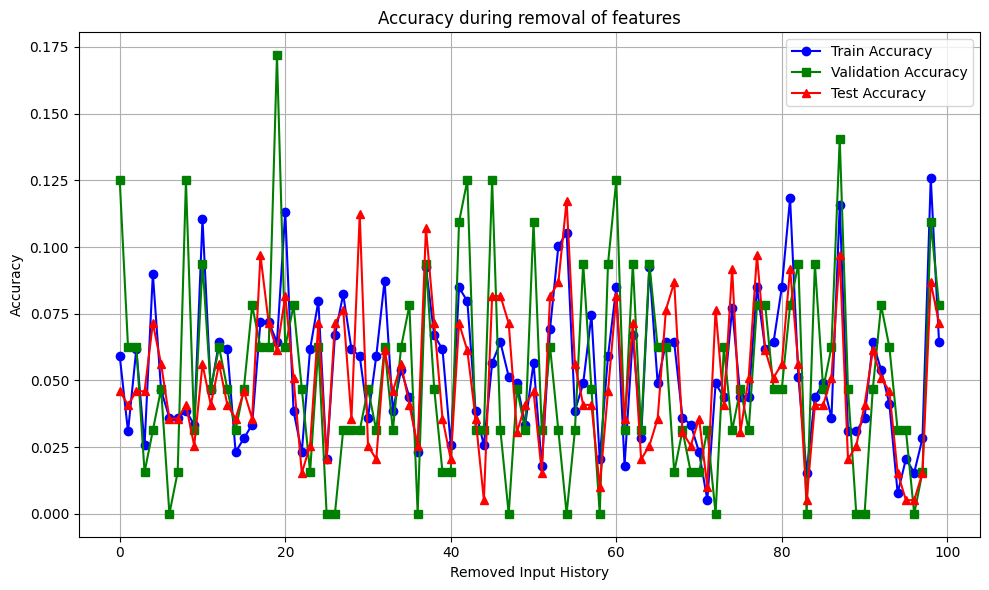

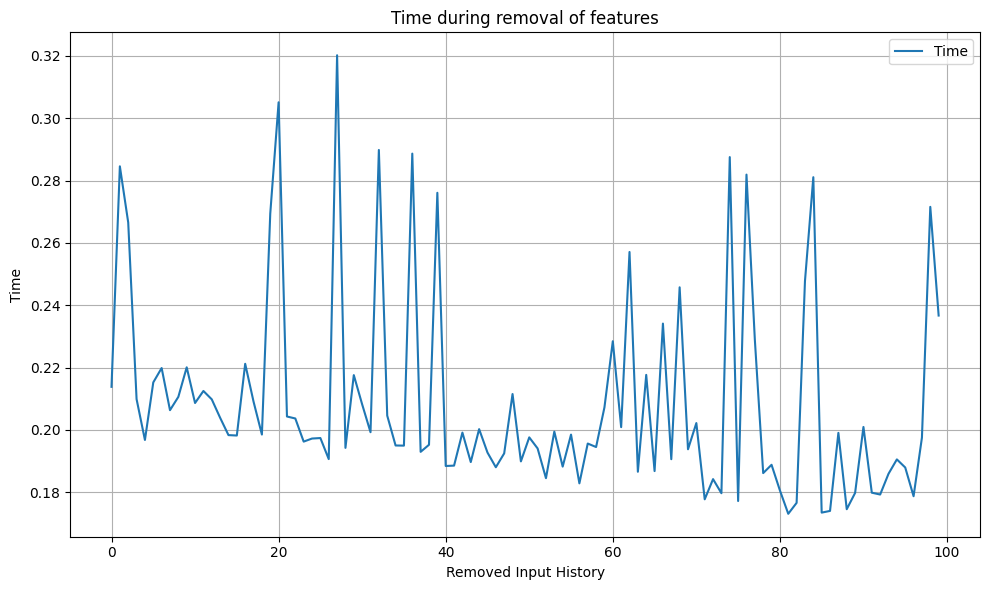

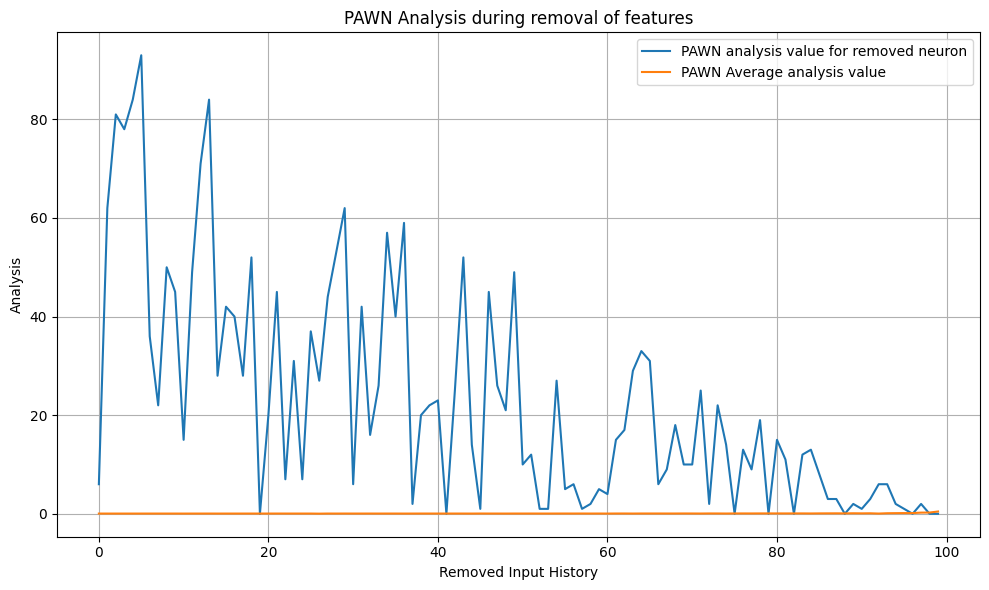

In [ ]:
print("removed_inputs_history:")
print(removed_inputs_history_second_pawn)
print("train_accuracy_history:")
print(train_accuracy_history_second_pawn)
print("valid_accuracy_history:")
print(valid_accuracy_history_second_pawn)
print("test_accuracy_history:")
print(test_accuracy_history_second_pawn)
print("time_history:")
print(time_history_second_pawn)
plot_accuracy(None, train_accuracy_history_second_pawn, valid_accuracy_history_second_pawn, test_accuracy_history_second_pawn)
plot_time(None, time_history_second_pawn)
plot_analysis(None, analysis_history_second_pawn, average_analysis_history_second_pawn, "PAWN")